# Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

# Load data

In [22]:
# X_A = pd.read_csv('../preprocessing/XA4Feaver.csv') # ,index_col=0 in MPS
# X_B = pd.read_csv('../preprocessing/X_feaver.csv') # ,index_col=0 in MPS
# Y_A = pd.read_csv('../preprocessing/Y_A.csv',index_col=0)

In [37]:
X_A = pd.read_csv('../preprocessing/X_A.csv',index_col=0)
X_B = pd.read_csv('../preprocessing/X_B.csv',index_col=0)
Y_A = pd.read_csv('../preprocessing/Y_A.csv',index_col=0)
lean_control_chips = pd.read_csv('../preprocessing/chip_lean_controls_indices.csv',index_col=0)
fatty_control_chips = pd.read_csv('../preprocessing/chip_fatty_controls_indices.csv',index_col=0)

In [38]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum()
print(varA)

1864.2939856979604


# Get PCA loadings

In [39]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

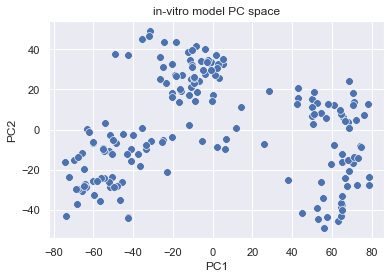

In [40]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [41]:
loadings = pca.components_
print(loadings.shape)

(179, 14322)


In [42]:
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 33.19 %


In [43]:
original_explained = 100*varAB/varA

# Initialize perturbation as a small random dX

In [44]:
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)

Iteration=0, loss=-0.3308, explained_variance=33.63%
Iteration=200, loss=-0.4124, explained_variance=41.33%
Iteration=400, loss=-0.4119, explained_variance=41.30%
Iteration=600, loss=-0.4122, explained_variance=41.36%
Iteration=800, loss=-0.4121, explained_variance=41.34%
Iteration=999, loss=-0.4120, explained_variance=41.32%
The new explained variance of the human data in the PC-space of liver chip is 40.79 %


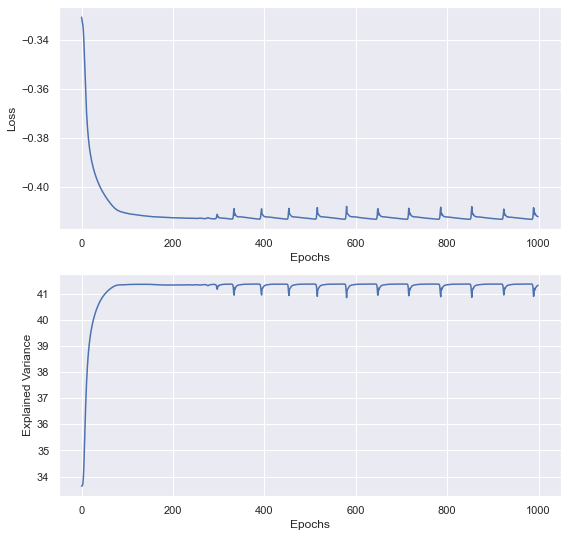

In [45]:
new_vars = []
df_pert = pd.DataFrame({})
fig, axs = plt.subplots(2,figsize=(9, 9))
XB_start = torch.mean(XB,0,keepdim= True)
dX = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,X_B.shape[1]))
dX = torch.tensor(dX).float().to(device)
Input_pert = torch.nn.Parameter(dX, requires_grad = True)
Input_pert.retain_grad()
optimizer = torch.optim.Adam([Input_pert],lr= 0.1,weight_decay=0)


loss_all = []
exp_var_all = []
iters = 1000
torch.autograd.set_detect_anomaly(True)
for i in range(iters):
    optimizer.zero_grad()
    Xstar = XB_start + Input_pert
    X = torch.concat((XB,Xstar),0)
    U,S,V = torch.svd(X)
    Z_A_B = torch.matmul(XA,V)
    varAB = torch.var(Z_A_B,axis=0).sum()

    loss = - varAB/varA
    loss = loss + 1e-6 * torch.sum(torch.abs(Input_pert))
    loss.backward()
    optimizer.step()

    exp_var = 100 * varAB/varA
    exp_var = exp_var.item()
    loss_all.append(loss.item())
    exp_var_all.append(exp_var)
    if i % 200 == 0 :
        outString = 'Iteration={:.0f}'.format(i)
        outString += ', loss={:.4f}'.format(loss.item())
        outString += ', explained_variance={:.2f}%'.format(exp_var)
        print(outString)
outString = 'Iteration={:.0f}'.format(i)
outString += ', loss={:.4f}'.format(loss.item())
outString += ', explained_variance={:.2f}%'.format(exp_var)
print(outString)
dx = pd.DataFrame(Input_pert.detach().cpu().numpy())
dx.columns = X_B.columns.values
df_pert = df_pert.append(dx)
axs[0].plot(range(iters),loss_all)
axs[1].plot(range(iters),exp_var_all)
axs[0].set(xlabel='Epochs', ylabel='Loss')
axs[1].set(xlabel='Epochs', ylabel='Explained Variance')

Xstar = XB_start + Input_pert
X = torch.concat((XB,Xstar),0)
X = X.detach().cpu().numpy()
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
loadings = pca.components_
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The new explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))
new_vars.append(100*varAB/varA)

In [46]:
df_pert

,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,...,DCAF15,CASP8AP2,NIPA1,ELP5,MIR23AHG,DDX51,YBX2,ISLR,C1R,PRKACA
0,-0.106262,0.092981,-0.066562,0.122405,-0.055703,0.003526,0.075115,-0.050481,0.034479,-0.074751,...,-0.027553,0.062357,0.087967,-0.044662,-0.071866,0.243183,-0.096127,-0.024329,0.075428,0.013568


In [47]:
df_pert.to_csv('../results/optimized_mps/dx_mean_mps.csv')

### Validate with sklearn

In [48]:
Xstar = XB + torch.tensor(df_pert.values).to(device)
X = torch.concat((XB,Xstar),0)
X = X.detach().cpu().numpy()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

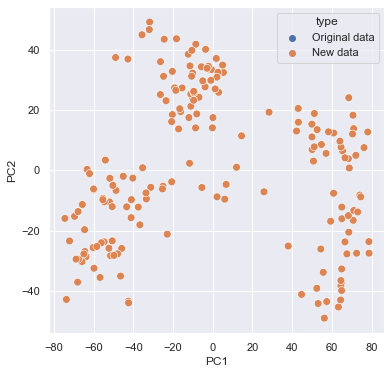

In [49]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
pca_data["type"] = ['Original data' for i in range(XB.shape[0])] + ['New data' for i in range(XB.shape[0])]
plt.figure(figsize=(6, 6))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [50]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(358, 14322)
The explained variance of the human data in the PC-space of liver chip is 42.07 %
